In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/garbage classification/Garbage classification"))
print(os.listdir('../input/garbage classification/'))

['glass', 'trash', 'paper', 'cardboard', 'plastic', 'metal']
['Garbage classification']


In [2]:
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob, os, random

Using TensorFlow backend.


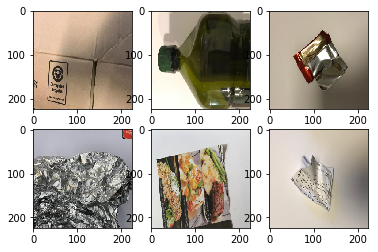

In [4]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
base_path = '../input/garbage classification/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [6]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 1s 0us/step


In [7]:
base_model.trainable = False

In [8]:
from tensorflow import keras
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(6, activation='sigmoid')
])

In [9]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [10]:
batch_size = 32
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
143/143 [==============================] - 34s 236ms/step - loss: 0.3634 - acc: 0.8511 - val_loss: 0.3156 - val_acc: 0.8579
Epoch 2/10
143/143 [==============================] - 29s 204ms/step - loss: 0.2594 - acc: 0.8954 - val_loss: 0.2959 - val_acc: 0.8679
Epoch 3/10
143/143 [==============================] - 30s 210ms/step - loss: 0.2313 - acc: 0.9059 - val_loss: 0.2738 - val_acc: 0.8845
Epoch 4/10
143/143 [==============================] - 30s 208ms/step - loss: 0.2192 - acc: 0.9135 - val_loss: 0.2469 - val_acc: 0.8865
Epoch 5/10
143/143 [==============================] - 30s 208ms/step - loss: 0.2055 - acc: 0.9175 - val_loss: 0.2415 - val_acc: 0.8971
Epoch 6/10
143/143 [==============================] - 30s 208ms/step - loss: 0.2038 - acc: 0.9181 - val_loss: 0.2250 - val_acc: 0.9004
Epoch 7/10
143/143 [==============================] - 30s 208ms/step - loss: 0.1929 - acc: 0.9225 - val_loss: 0.1978 - val_acc: 0.9183
Epoch 8

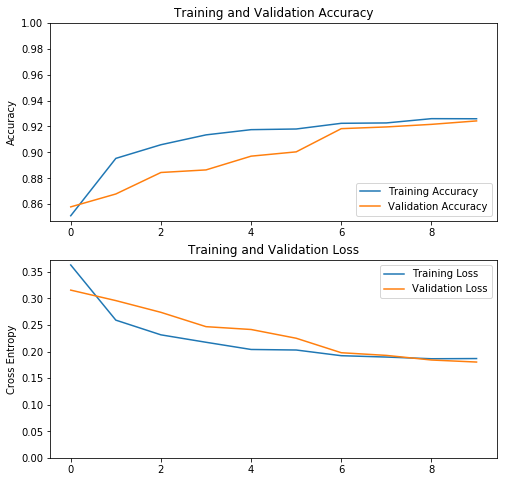

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Fine Tuning

In [12]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [13]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 1,870,278
Non-trainable params: 395,392
_________________________________________________________________


In [14]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Epoch 1/10
143/143 [==============================] - 34s 239ms/step - loss: 0.1757 - acc: 0.9298 - val_loss: 0.1774 - val_acc: 0.9263
Epoch 2/10
143/143 [==============================] - 29s 205ms/step - loss: 0.1550 - acc: 0.9410 - val_loss: 0.1737 - val_acc: 0.9276
Epoch 3/10
143/143 [==============================] - 31s 214ms/step - loss: 0.1449 - acc: 0.9438 - val_loss: 0.1634 - val_acc: 0.9329
Epoch 4/10
143/143 [==============================] - 30s 213ms/step - loss: 0.1303 - acc: 0.9503 - val_loss: 0.1559 - val_acc: 0.9402
Epoch 5/10
143/143 [==============================] - 30s 211ms/step - loss: 0.1165 - acc: 0.9566 - val_loss: 0.1526 - val_acc: 0.9382
Epoch 6/10
143/143 [==============================] - 30s 207ms/step - loss: 0.1105 - acc: 0.9587 - val_loss: 0.1502 - val_acc: 0.9376
Epoch 7/10
143/143 [==============================] - 30s 207ms/step - loss: 0.0987 - acc: 0.9633 - val_loss: 0.1508 - val_acc: 0.9429
Epoch 8/10
143/143 [==============================] - 3

In [15]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

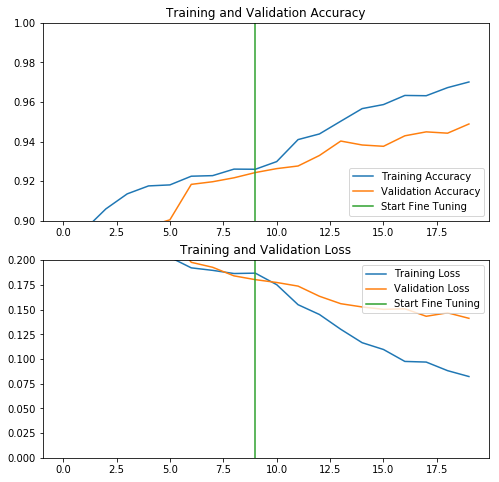

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()